# msld_py_prep Tutorial for Streamlined MS$\lambda$D Small Molecule Setup

### This tutorial assumes that you are working within a Conda environment and that you have the following tools already loaded:
- PyMOL
- ParamChem (CGenFF module)
- MMTSB 
- RDKit Python Package
- Pandas 1.3.4 Python Package
... and of course, pyCHARMM

## Problem we are trying to solve: 
Find a set of common atoms across a molecule set such that the atom type connectivity and atom charges are the same. This is a necessary requirement for MSLD since we need to fragment molecules into a `common core` and the respective substituent fragments per site of variation.

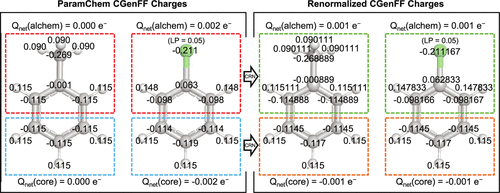

While the atom type connectivity is relatively easy to find using a Maximum Common Substructure (MCS) search (as we do here), the partial charges of common atoms across similar molecules differ. This is why we perform charge renormalization to get the charges across common atoms to be the same, as shown in the figure above.

### The diagram below shows the typical workflow the msld_py_prep scripts use in order to get files that solve the problem described above.

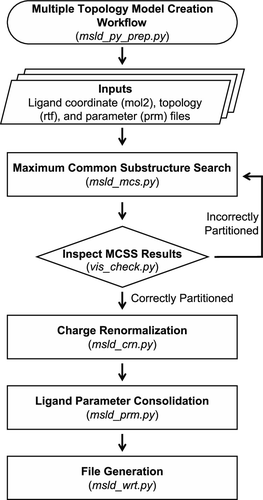

#### "Optimizing Multisite λ-Dynamics Throughput with Charge Renormalization" Jonah Z. Vilseck, Luis F. Cervantes, Ryan L. Hayes, and Charles L. Brooks Journal of Chemical Information and Modeling 2022 62 (6), 1479-1488; DOI: 10.1021/acs.jcim.2c00047

## I. Set Up Dependencies

We need to make sure we have the msld_py_prep scripts cloned, RDKit installed, PyMOL set up, and that we have a ParamChem module installed and aliased as 'cgenff' ready to use on the terminal

In [1]:
# Clone msld_py_prep GitHub repo
! git clone https://github.com/Vilseck-Lab/msld-py-prep.git

Cloning into 'msld-py-prep'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 814 (delta 5), reused 1 (delta 1), pack-reused 791
Receiving objects: 100% (814/814), 1.36 MiB | 600.00 KiB/s, done.
Resolving deltas: 100% (341/341), done.


In [1]:
# Install RDKit, pyMOL and pandas to your conda environment if you do not have it already.
# Otherwise use the command below

# Assuming you have a conda environment loaded)
! printf 'y' | conda install -n $CONDA_DEFAULT_ENV -c schrodinger rdkit pymol pandas=1.3.4

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/luiscv/opt/anaconda3/envs/pymol

  added / updated specs:
    - pandas
    - pymol
    - rdkit


The following packages will be UPDATED:

  libgfortran              conda-forge::libgfortran-3.0.1-0 --> schrodinger::libgfortran-3.0.1-2000
  pmw                conda-forge/osx-64::pmw-2.0.1-py38h50~ --> schrodinger/noarch::pmw-2.0.1+3-py_3
  tk                 

In [2]:
# Check that we have a ParamChem module in our setup
# aliased as 'cgenff', as well as pyMOL and MMTSB ready to go,
# specifically the convpdb.pl script


! which cgenff
! which pymol
! which convpdb.pl

cgenff not found
/Users/luiscv/opt/anaconda3/envs/pymol/bin/pymol
convpdb.pl not found


NOTE: if you are running locally, chances are you might not have the cgenff module installed. If that is the case, the parameter files for the ligands generated herein are located in the `jnk1_ligands` directory

## II. Curating a Small Molecule Dataset for Input into MSLD

In a prospective MSLD small-molecule/protein binding study, one usually starts out with a crystal structure of an active lead compound bound to the protein target of interest. The goal is to make small modifications to the ligand scaffold in order to predict changes that will increase affinity or retain it while improving other properties (e.g. solubility). 

We will start by filtering a substructure from the ChEMBL database of the scaffold for the lead compound shown below, which binds to c-Jun N-terminal Kinase 1 (JNK1),  an important protein target for cancer and neurodegenerative disease treatment. 

<div>
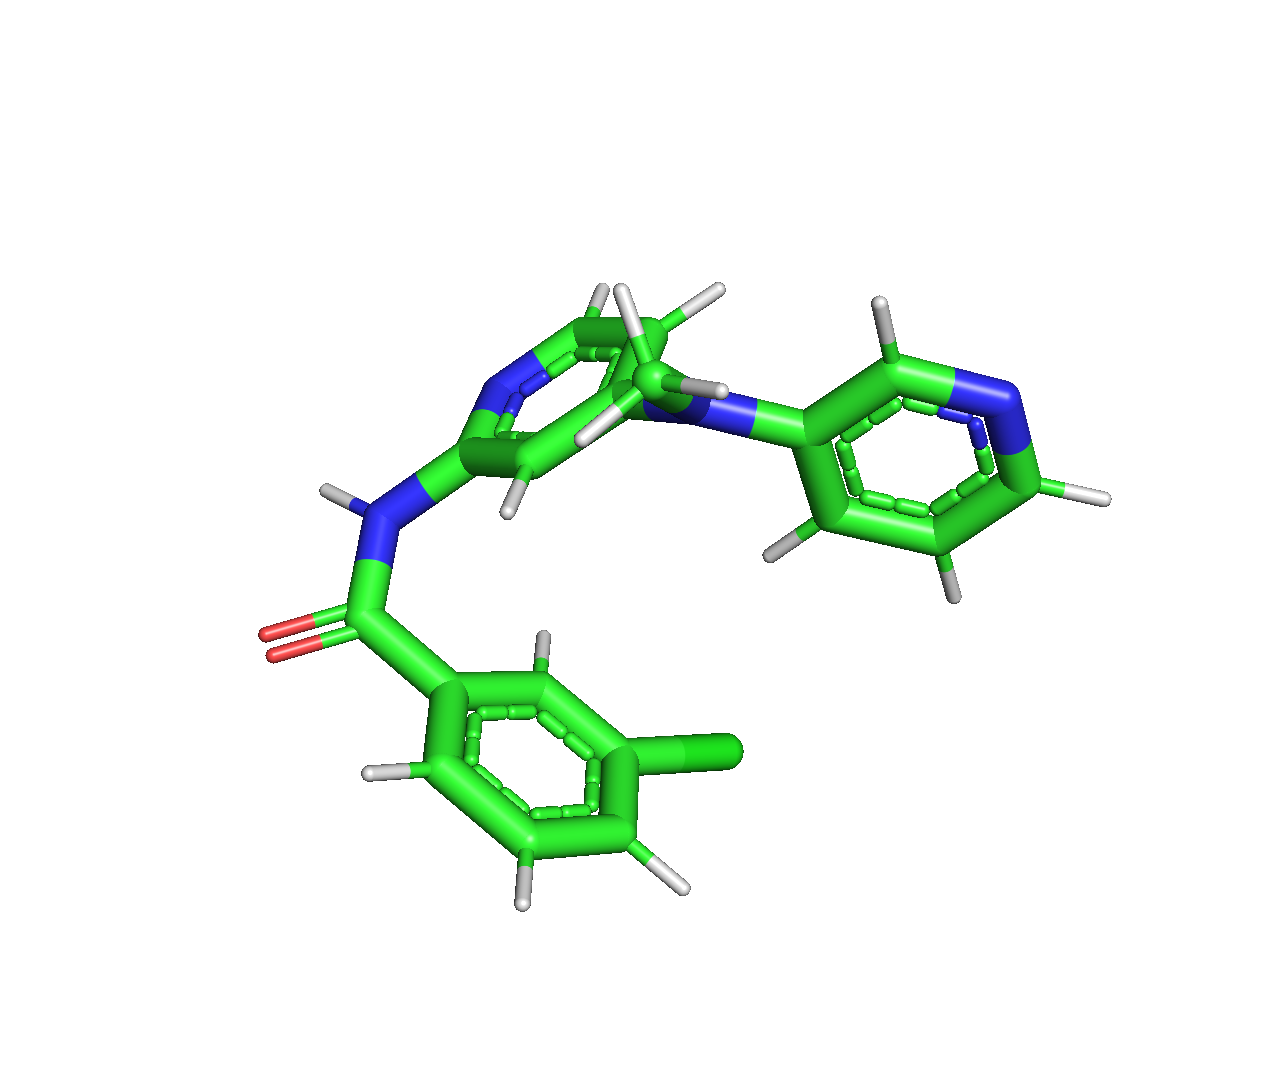
</div>

Matching molecules to pattern...
Done.

ChEMBL ID,Smiles
CHEMBL3655647,CN(c1cccnc1)c1ccnc(NC(=O)c2cccc(Cl)c2)c1
CHEMBL3818832,CC(C)C(=O)Nc1cc(Nc2c(Cl)ccc3c2OCO3)ccn1
CHEMBL3818920,CCC(=O)Nc1cc(Nc2c(Cl)ccc3c2OCO3)ccn1
CHEMBL3819276,O=C(Nc1cc(Nc2c(Cl)ccc3c2OCO3)ccn1)C1CCC1


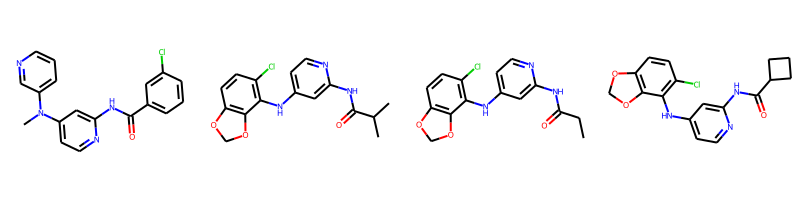

In [2]:
from generate_3D import RDKit_Tools
from IPython.display import Image


dataset = "CHEMBL_Dataset.csv"
dfout= "filtered_df.csv"
# pattern1 = "C12=C(C(CCCOC)=C(C(=O)O[H])N2)C=CC=C1"
# pattern1 = "N1(C(C(=O)NCc2cccc(c2))CCC1)C"
pattern1 = "c1nc(cc(N)c1)NC(=O)C"
names_col = "ChEMBL ID"
smiles_col = "Smiles"
delim=";"
delimout=","
    

mols = RDKit_Tools(dataset, smiles_col=smiles_col, names_col=names_col,delim=delim) # Load molecules into RDKit
matches,indices = mols.filter_molecules(pattern1) # Filter based on smiles pattern
mols.draw_smiles("filtered_mols.png",matches[:50]) # Visualize filtered molecules
mols.get_dataframe(save=dfout,filter_idx=indices, delim=delimout) # Save as csv

! cat filtered_df.csv
Image(filename='filtered_mols.png') # Display molecules

We were lucky enough to retrieve the lead compound (CHEMBL3655647) in our curated dataset!

In [3]:
# Since cgenff might not be available, I am copying the *str files onto the msld-py-prep
# directory that we would otherwise generate with the plugin in the next step.
import os

! cp lead.mol2 filtered_df.csv jnk1_ligands/*str msld-py-prep
os.chdir('msld-py-prep')
!ls

CHEMBL3818832.str README.md         msld_chk.py       rename_atoms.py
CHEMBL3818920.str examples          msld_crn.py       toppar
CHEMBL3819276.str filtered_df.csv   msld_mcs.py       vis_check.py
CRN_Plugin        lead.mol2         msld_prm.py
Lg_Solvate.sh     lead.str          msld_py_prep.py
NOTES             mol_list.txt      msld_wrt.py


### Now that we have found some new molecules from the ChEMBL database based on the lead scaffold, we now have to generate their 3D structures and align them to the lead compound. 
We can do that via our PyMOL plugin. We will initialize PyMOL by opening the lead compound typing this in a terminal window: 
`pymol -R lead.mol2 &`

To install the PyMOL plugin click: `Plugin tab -> Plugin Manager -> Install New Plugin Tab -> Install from local file "Choose File" button`, then navigate to and select the CRN_Plugin/__init__.py script. Once installed you can find the plugin in the dropdown menu of the Plugin tab.

Input these specs into the plugin and click the `Align` button to generate mol2 files that are aligned to the lead compound. **Specify the msld-py-prep directory** when asked where you want to save the output of the alignment.
<div>
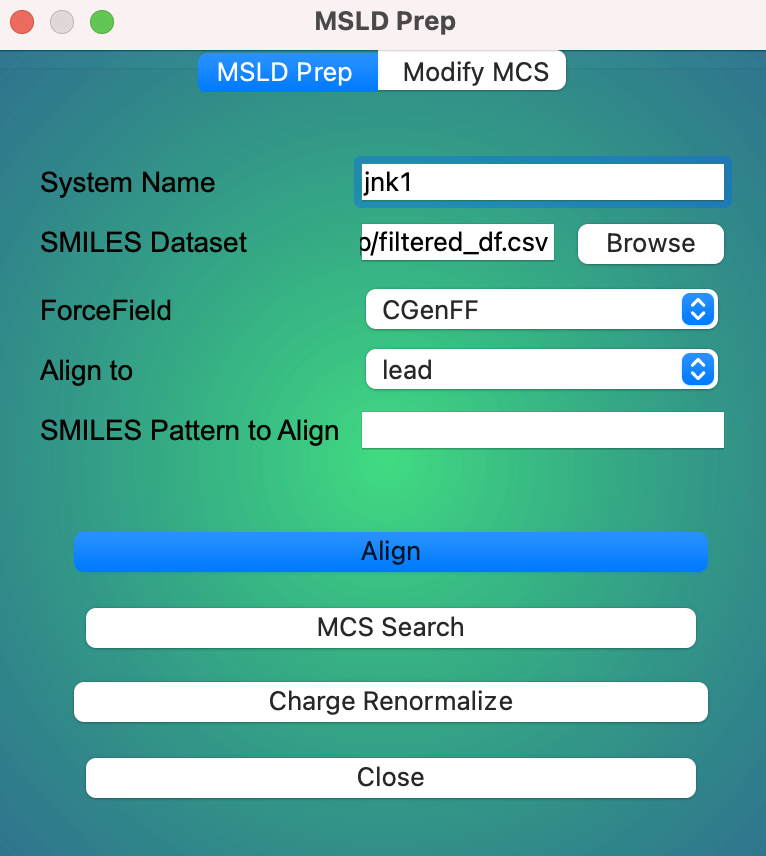
</div>

You should now have aligned molecules with their corresponding .mol2 files. Your PyMOL window should look like this:


<div>
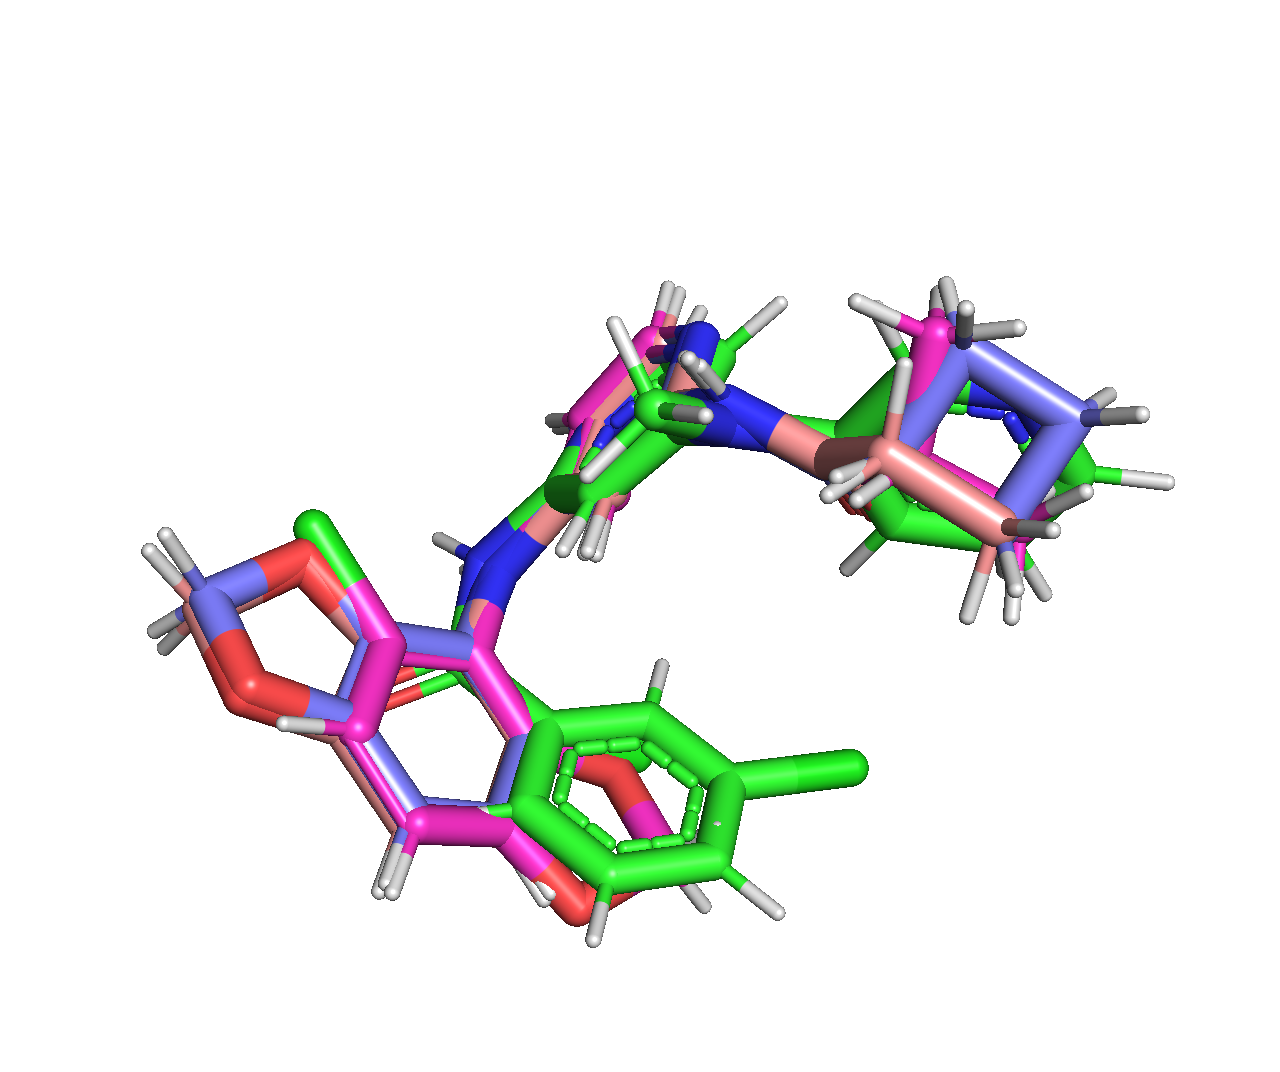
</div>

Notice that all the molecules shown have the same moiety at the bottom, yet for some molecules they are flipped. The orientation of the moiety will depend on your binding pocket. We manually need to tweak some torsions to have this moiety aligned before moving on. 


<div>
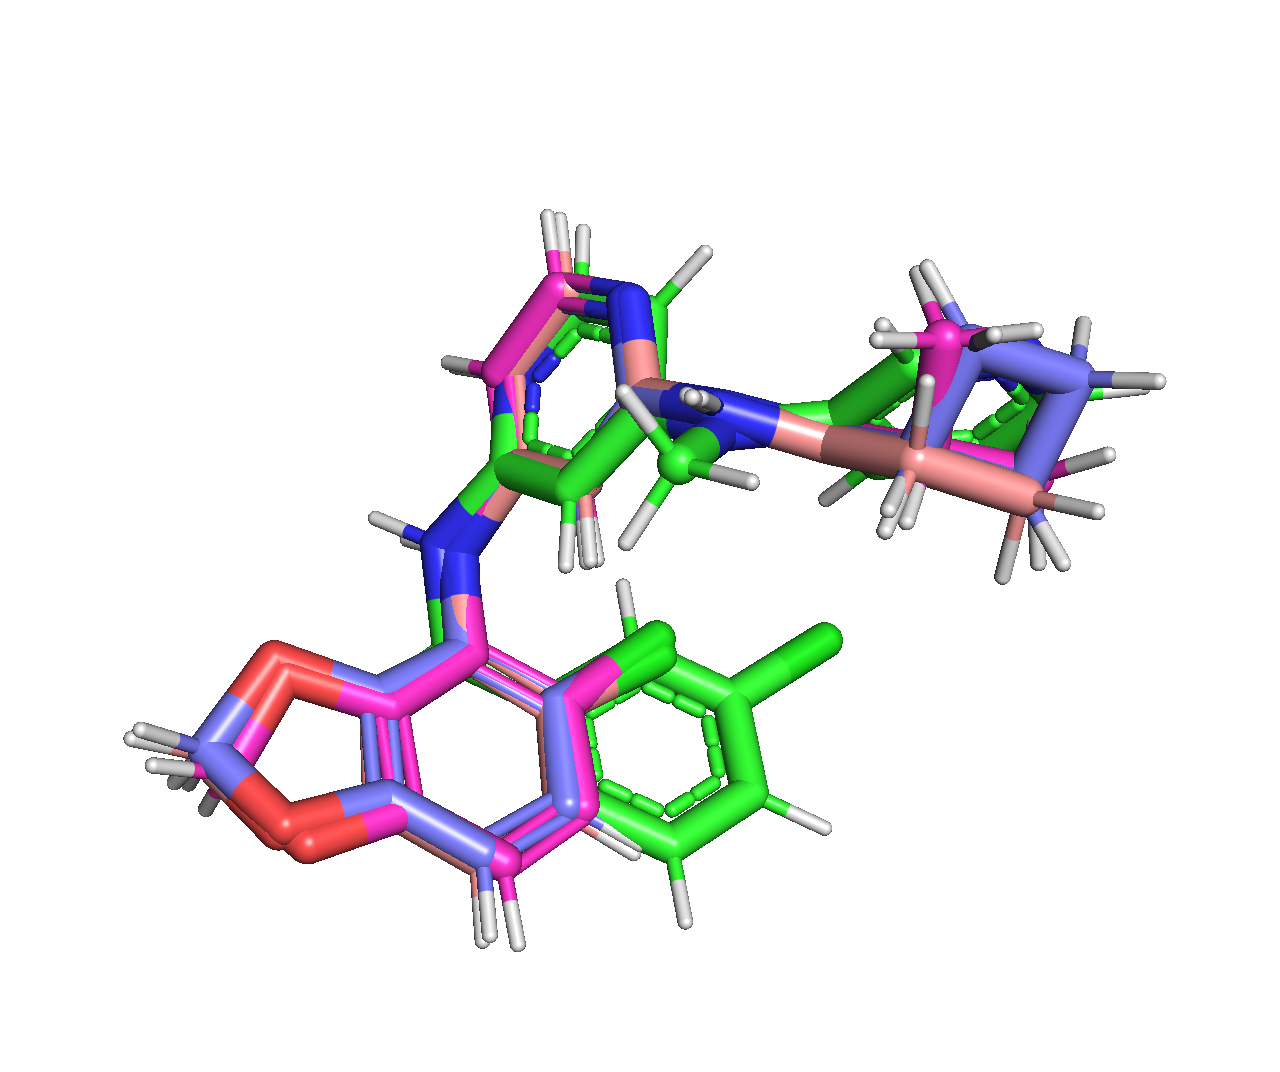
</div>

#### Notice something unusual about all of the aligned ligands and the lead compound (green)?
Because of this unusual alignment output, we will leave out the lead compound for this tutorial since this requires some more complex modification (rotation) of the molecules to align with the lead compound. 
#### It should be noted, however, that you usually want your lead compound to be included in the MSLD setup, since it's usually the only experimentally proven binder in your MSLD dataset in a prospective study.

In the plugin, all that is necessary to exclude the lead ligand is to disable it on the object window. 
<div>
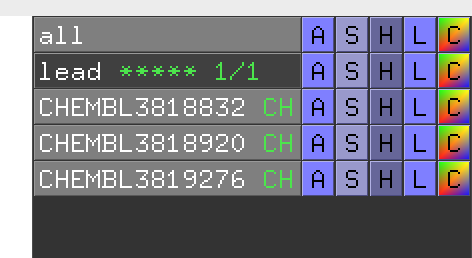
</div>
Proceed to Part III to show how we would do this on the command line.

## III. Setting up a Hybrid Topology System Using Charge Renormalization

Now that we have aligned molecules with a CHARMM compatible parameter/topology and a mol2 file, we can proceed in the plugin by clicking each button sequentially. We can also run msld_py_prep from the command line as follows:

In [16]:
!pwd

/Users/luiscv/umich/research/msldpp_test/msld-py-prep


In [14]:
# Specify molecules you wish to do crn on
! rm mol_list.txt
! echo CHEMBL3818832 >> mol_list.txt
! echo CHEMBL3818920 >> mol_list.txt
! echo CHEMBL3819276 >> mol_list.txt

# Specify system name in msld_py_prep.py
! sed 's/\"name\"/\"jnk1\"/g' msld_py_prep.py | tee msld_py_prep.py

# Run MCS Step
! python msld_py_prep.py
! cat MCS_for_MSLD.txt

#! /usr/bin/env python

####
#### Executable script to build MSLD ready ligand files
#### JV,LC 01/2022
####

import msld_chk
import msld_mcs
import msld_crn
import msld_prm
import msld_wrt
import glob

###
### This script is executed in 2 steps to (1st) build the MCSS
### and (2nd) perform charge renormalization. This allows the user
### to check that the identified MCSS is correct with vis_check.py.
### Thus, the user should manually call msld_py_prep.py twice.
###
### All ligand structure files (mol2) and toppar files must be 
### available prior to running this script
###
### The inFrag list of lists allows you to move core atoms into 
### alchemical fragments at specific sites. Each nested list 
### corresponds to a single site attached to the ligand core.
###
### The AnCore list of lists allows you to move (non-DUM) atoms
### listed as "anchor atoms" (atoms connecting core and fragment
### components) into the core upon charge renormalization.
###


##############################

In [17]:
# Visualize 
from rdkit.Chem import PyMol
v = PyMol.MolViewer()
v.server.do('run vis_check.py')

After running this either through the `run vis_check.py` command or through the plugin after pressing the `MCS Search` button, you should get the following:


<div>
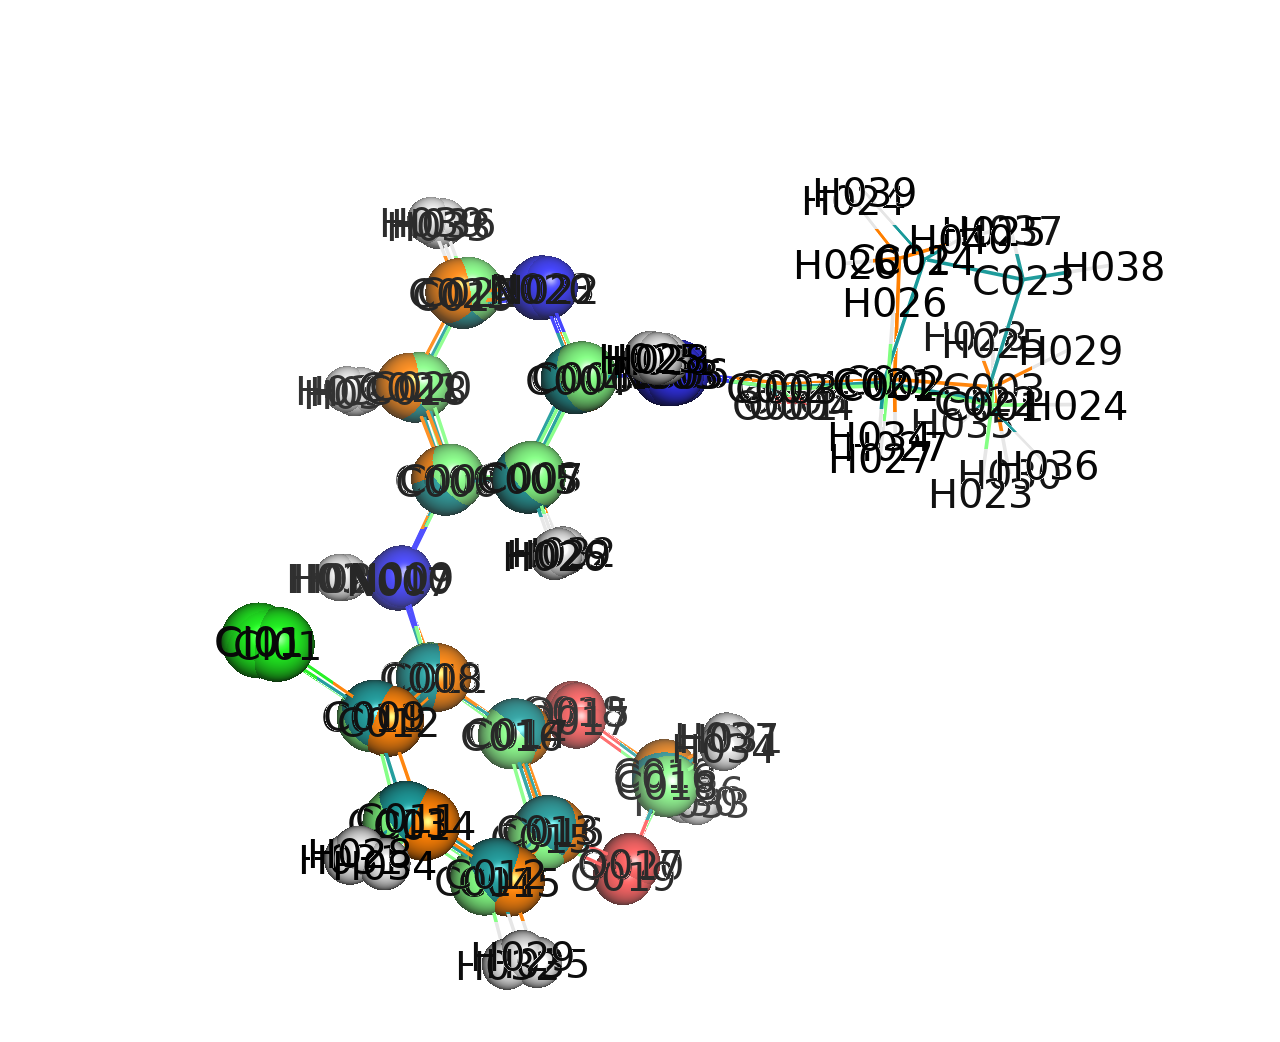
</div>

Atoms shown as hard spheres are part of the `core` and the ones shown as stick are `substituents`, which we will be transforming alchemically throughout the MSLD simulation. In this case we only have one single site.

We sometimes get disconnected cores and this is an issue for regular MSLD, which is why we want to modify the MCS a little bit before proceeding. Atom O005 in molecule CHEMBL3818832 has been marked as part of the core. Since it is not connected to any other core atoms, we have a disconnected core.

To fix this in the plugin, go on edit mode and select this atom in this molecule (you can also select the corresponding atom in the other molecules). Once the atom is selected in edit mode, we can exclude it from the core by pressing the `Move` button and making the following specifications.

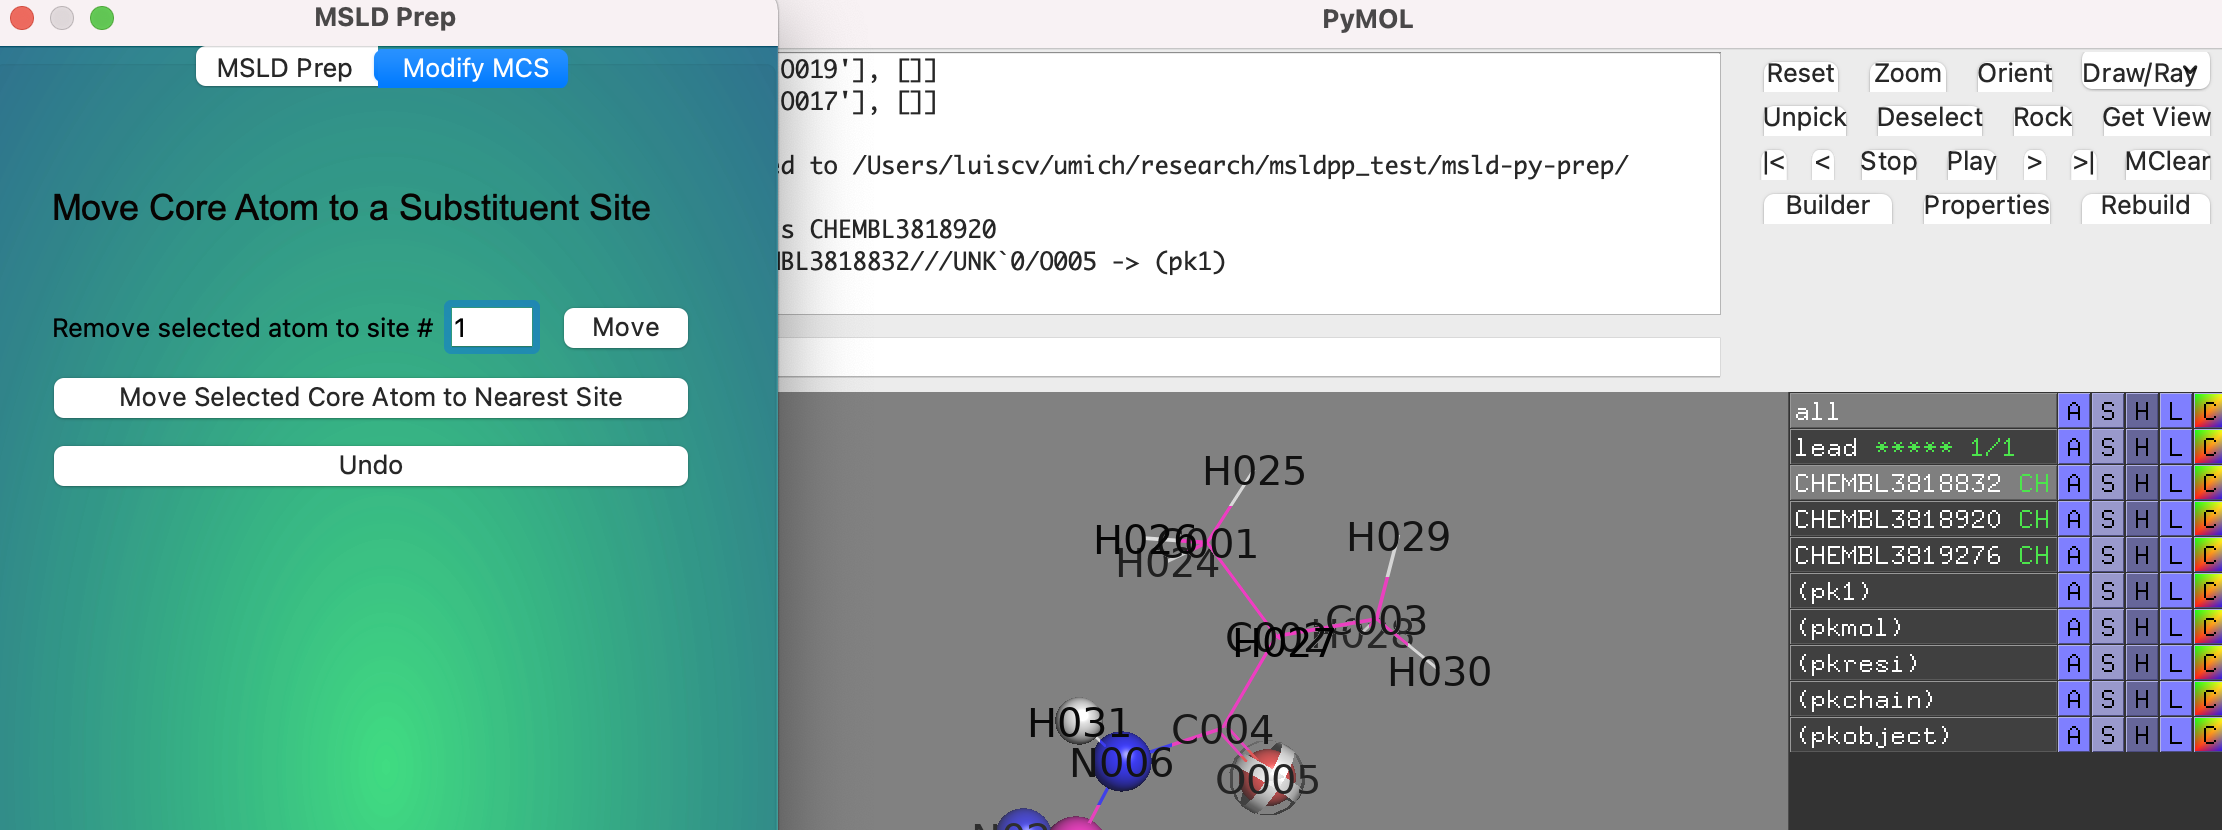

Since we only have one site of variation in this system, we have specified that we want to move it to site 1.

We are now ready to do the charge renormalization step, along with the fragmenting of the molecules in order to separate the core from the different fragments/substituents. This should output a directory called `build.jnk1`

In [ ]:
# Run charge renormalization Step 
# (Same command as for MCS Step but scripts identify that we have an `MCS_for_MSLD.txt` file)
! python msld_py_prep.py

### We need to pay close attention to the output to see if we have not changed the charges significantly.

Now that we have made sure that we have not altered the charges as much, we can visualize the pdb files in the `build.jnk1` directory to make sure that we have a correct fragmentation.


<div>
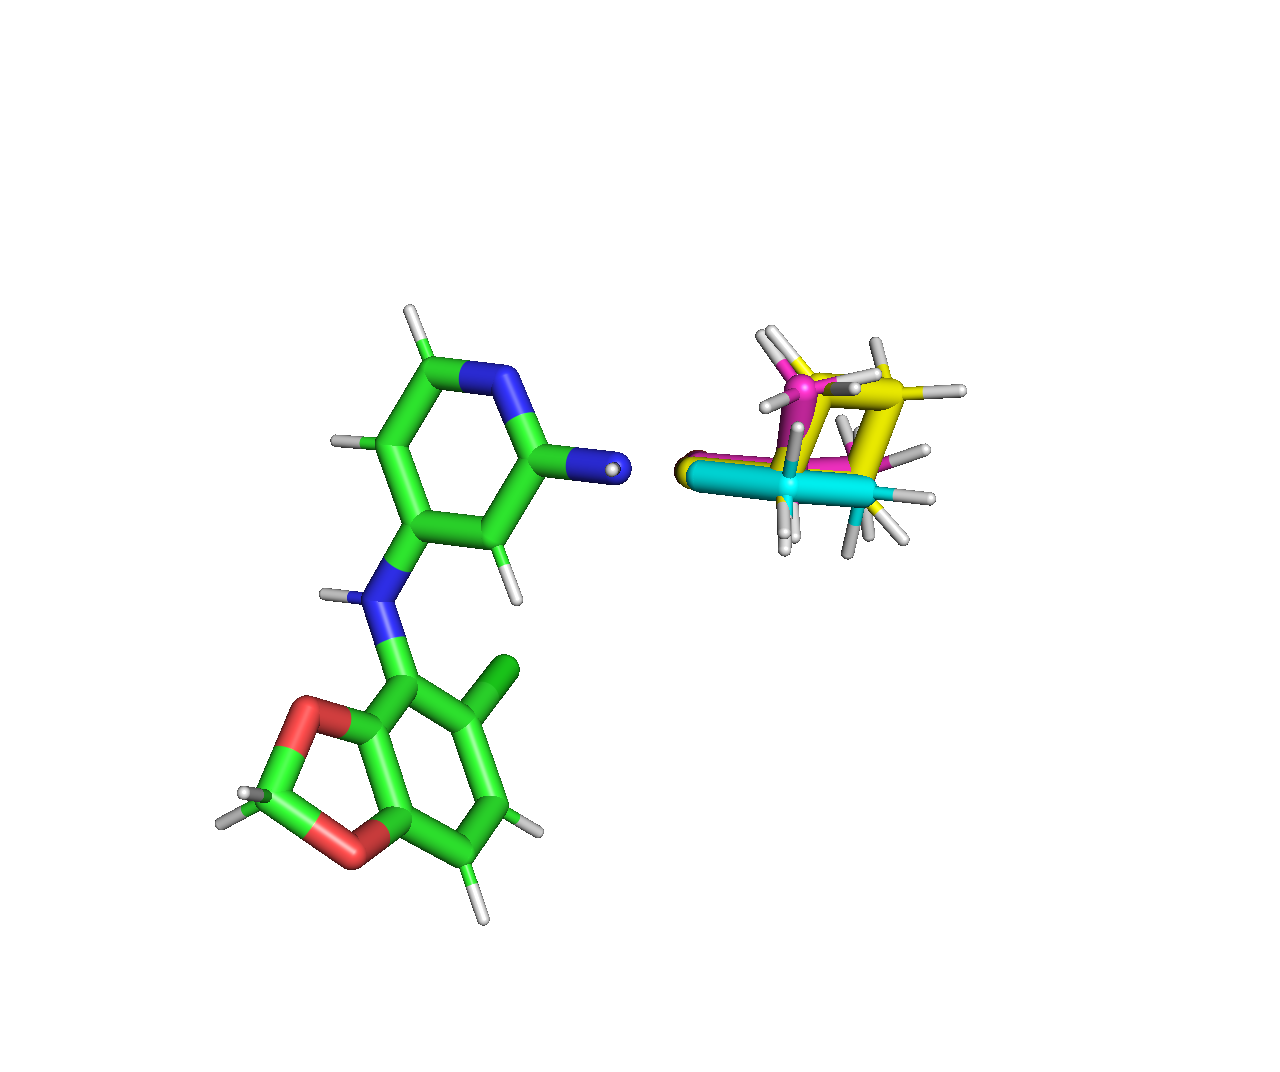
</div>

### We are done! 
With the correct pdb, rtf, and prm files, as well as a CHARMM MSLD script (`jnk1.inp`) in the `build.jnk1` directory, we are ready for input into MSLD and pyCHARMM.

## pyCHARMM Import

In [ ]:
import os
import sys
import numpy as np

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm